In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join
import pydicom
import cv2
from functools import reduce
from glob import glob
from tqdm.notebook import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset_dir = '/efs/xray-detect/datasets/vinbigdata/raw/'
train_dir = f'{dataset_dir}/train'
test_dir = f'{dataset_dir}/test'

In [3]:
# Read example dicom
sample_id = '000434271f63a053c4128a0ba6352c7f'
path_file = join(train_dir, f'{sample_id}.dicom')
example = pydicom.read_file(path_file)
print(type(example))
print(example)

<class 'pydicom.dataset.FileDataset'>
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 156
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 000434271f63a053c4128a0ba6352c7f
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: ''
(0002, 0016) Source Application Entity Title     AE: 'VITREA1'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'O'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME1'
(0028, 0010) Rows                                US: 2836
(0028, 0011) Columns                             US: 2336


In [42]:
example.BitsStored = 16

In [43]:
example.pixel_array

array([[2871, 2858, 2833, ..., 3973, 3977, 3988],
       [3064, 3033, 3022, ..., 3999, 4003, 4002],
       [3241, 3207, 3193, ..., 4014, 4013, 4016],
       ...,
       [4087, 4089, 4083, ..., 4089, 4095, 4093],
       [4087, 4089, 4082, ..., 4088, 4095, 4093],
       [4087, 4090, 4083, ..., 4089, 4095, 4093]], dtype=uint16)

In [48]:
def dicom2arr(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    dicom.BitsStored = dicom.BitsAllocated
    data = apply_voi_lut(dicom.pixel_array, dicom) if (voi_lut) else dicom.pixel_array
    if (fix_monochrome and (dicom.PhotometricInterpretation == "MONOCHROME1")):
        data = np.amax(data) - data
    data = data.astype(np.float)
    data -= np.min(data)
    data /= np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [49]:
arr_example = dicom2arr(path_file)
print(arr_example)

[[76 76 78 ...  7  7  6]
 [64 66 66 ...  5  5  5]
 [53 55 56 ...  4  5  4]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [50]:
def visualize_data(info_imgs, figsize=None, color_map=None, thickness=10, axes_shape=None):
    num_imgs = len(info_imgs)
    fig, axes = plt.subplots(num_imgs//axes_shape[1] + (1 if (num_imgs % axes_shape[1] != 0) else 0), axes_shape[1], figsize=figsize)
    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            img = info_imgs[i * axes.shape[1] + j]["img"]
            bboxes = info_imgs[i * axes.shape[1] + j].get("bboxes", None)
            title = info_imgs[i * axes.shape[1] + j].get("title", None)
            if (bboxes is not None):
                for k, bbox in enumerate(bboxes):
                    img = cv2.rectangle(img, tuple(bbox[:2]), tuple(bbox[2:]), color_map[info_imgs[i * axes.shape[1] + j]["class_id"][k]], thickness)
            axes[i, j].imshow(img, cmap="gray")
            if (title is not None):
                axes[i, j].set_title(title)
    plt.show()
    return

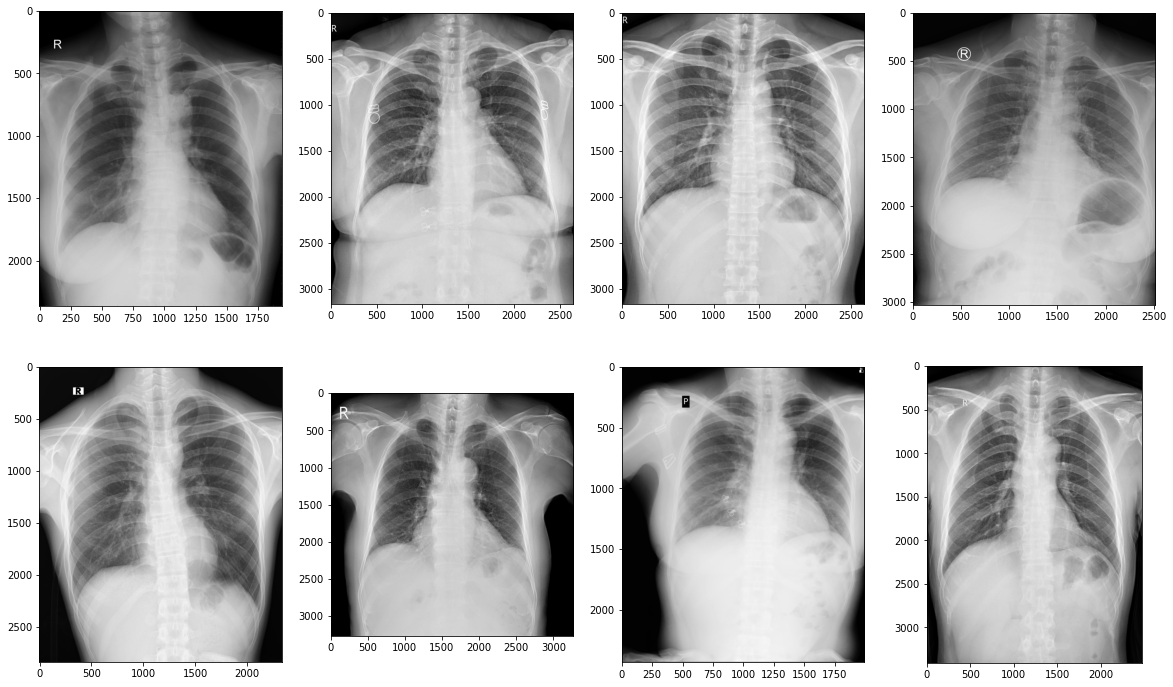

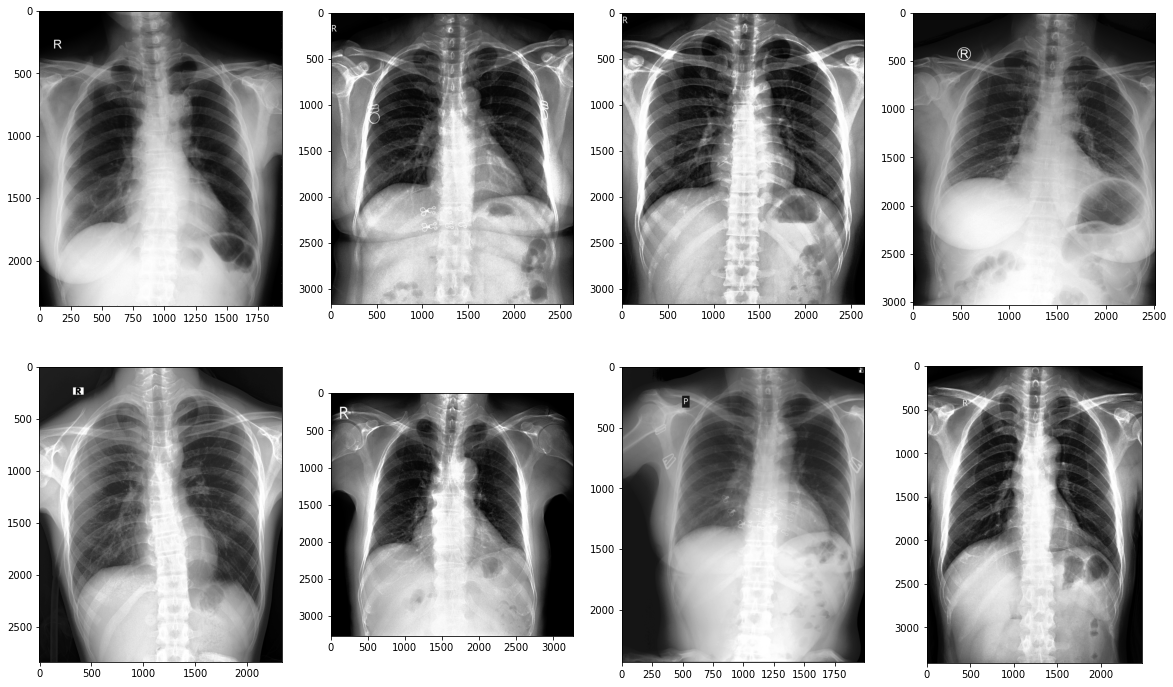

In [51]:
dicom_paths = glob(f'{dataset_dir}/train/*.dicom')[:8]
imgs = [{"img": dicom2arr(path)} for path in dicom_paths]
visualize_data(imgs, figsize=(20, 12), axes_shape = (-1, 4))

# Visualize img with histogram equalization to obtain high contrast image
preprocess_imgs = [{"img": cv2.equalizeHist(img["img"])} for img in imgs]
visualize_data(preprocess_imgs, figsize=(20, 12), axes_shape = (-1, 4))

In [52]:
from bokeh.plotting import figure as bokeh_figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs
import pandas as pd
from PIL import Image
from sklearn import preprocessing
import random
from random import randint


train_df = pd.read_csv(f'{dataset_dir}/train.csv')

# convert rad_id to int type
le = preprocessing.LabelEncoder()
train_df['rad_label'] = le.fit_transform(train_df['rad_id'])
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,rad_label
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,14
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,1
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,1
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,1


In [53]:
train_df.shape, len(train_df.image_id.unique())

((67914, 9), 15000)

In [54]:
print("Number of radiologists: ", le.classes_.shape[0])
print("Radiologists: ", le.classes_)

Number of radiologists:  17
Radiologists:  ['R1' 'R10' 'R11' 'R12' 'R13' 'R14' 'R15' 'R16' 'R17' 'R2' 'R3' 'R4' 'R5'
 'R6' 'R7' 'R8' 'R9']


In [55]:
diseases, counts = np.unique(test_df["class_name"].values, return_counts=True)
print("Number of classes: ", diseases.shape[0])

Number of classes:  15


Blue:  Aortic enlargement
Green:  Atelectasis
Red:  Calcification
Pink:  Cardiomegaly
Yellow:  Consolidation
Aqua:  ILD
Purple:  Infiltration
Orange:  Lung Opacity
Black:  Nodule/Mass
White:  Other lesion
Brown:  Pleural effusion
Wheat:  Pleural thickening
Gray:  Pneumothorax
Burgundy:  Pulmonary fibrosis


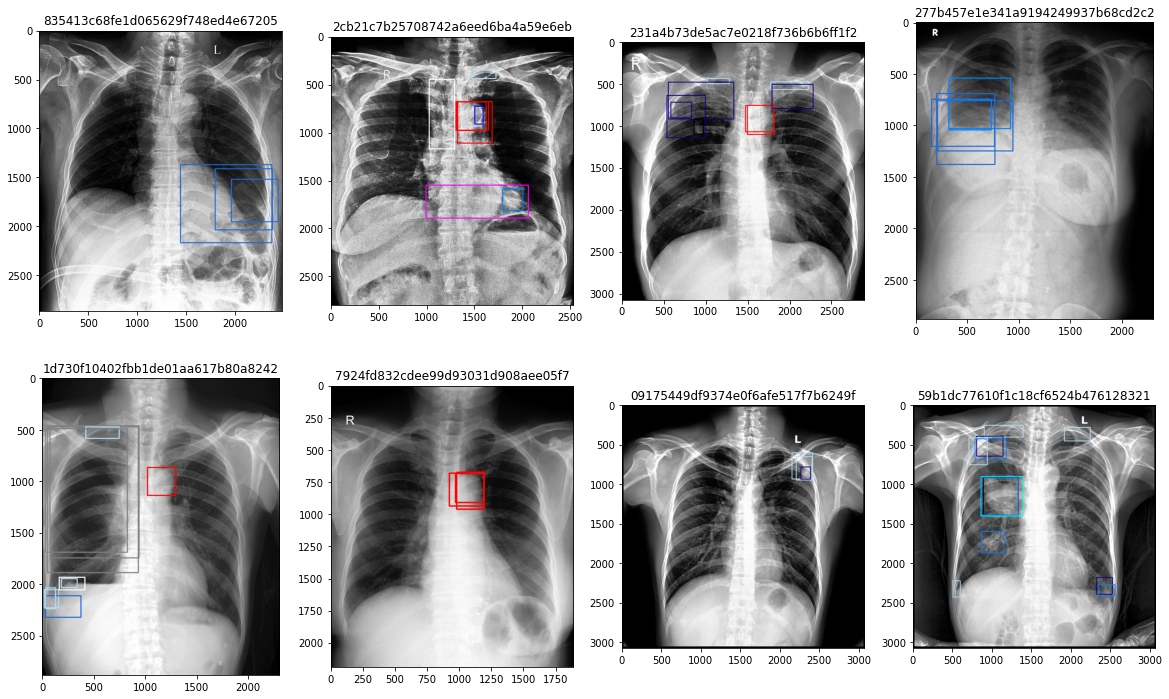

In [56]:
info_imgs = []
color_map = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 0, 255), (0, 255, 255), (255, 255, 0), (255, 51, 187), (0, 128, 255), (0, 0, 0), (255, 255, 255), (30, 105, 210), (179, 222, 245), (128, 128, 128), (21, 0, 128)]
color_name = ["Blue", "Green", "Red", "Pink", "Yellow", "Aqua", "Purple", "Orange", "Black", "White", "Brown", "Wheat", "Gray", "Burgundy"]
classes_name = ["Aortic enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung Opacity", "Nodule/Mass", "Other lesion", "Pleural effusion", "Pleural thickening", "Pneumothorax", "Pulmonary fibrosis", "No finding"]

for i in range(diseases.shape[0] - 1):
    print(f"{color_name[i]}: ", classes_name[i])

identifiers = pd.unique(train_df.loc[train_df["class_id"] != 14]["image_id"])
indexes = np.random.permutation(identifiers.shape[0])[:8]

for index in indexes:
    identifier_df = train_df.loc[train_df["image_id"] == identifiers[index], ["class_name", "x_min", "y_min", "x_max", "y_max", "class_id"]]
    img = dicom2arr(f'{train_dir}/{identifiers[index]}.dicom')
    img = cv2.equalizeHist(img) 
    img = np.repeat(np.expand_dims(img, axis=-1), 3, axis=-1)
    class_name = identifier_df.iloc[0]["class_name"]
    bboxes = None
    classes = None
    if (class_name != classes_name[-1]):
        bboxes = []
        classes = []
        identifier_df.apply(lambda x: bboxes.append([int(x["x_min"]), int(x["y_min"]), int(x["x_max"]), int(x["y_max"])]), axis=1)
        identifier_df.apply(lambda x: classes.append(x["class_id"]), axis=1)
    info_imgs.append({"img": img, "bboxes": bboxes, "title": identifiers[index], "class_id": classes})

visualize_data(info_imgs, figsize=(20, 12), color_map=color_map, thickness=10, axes_shape=(-1, 4))

/home/ubuntu/anaconda3/envs/xray/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


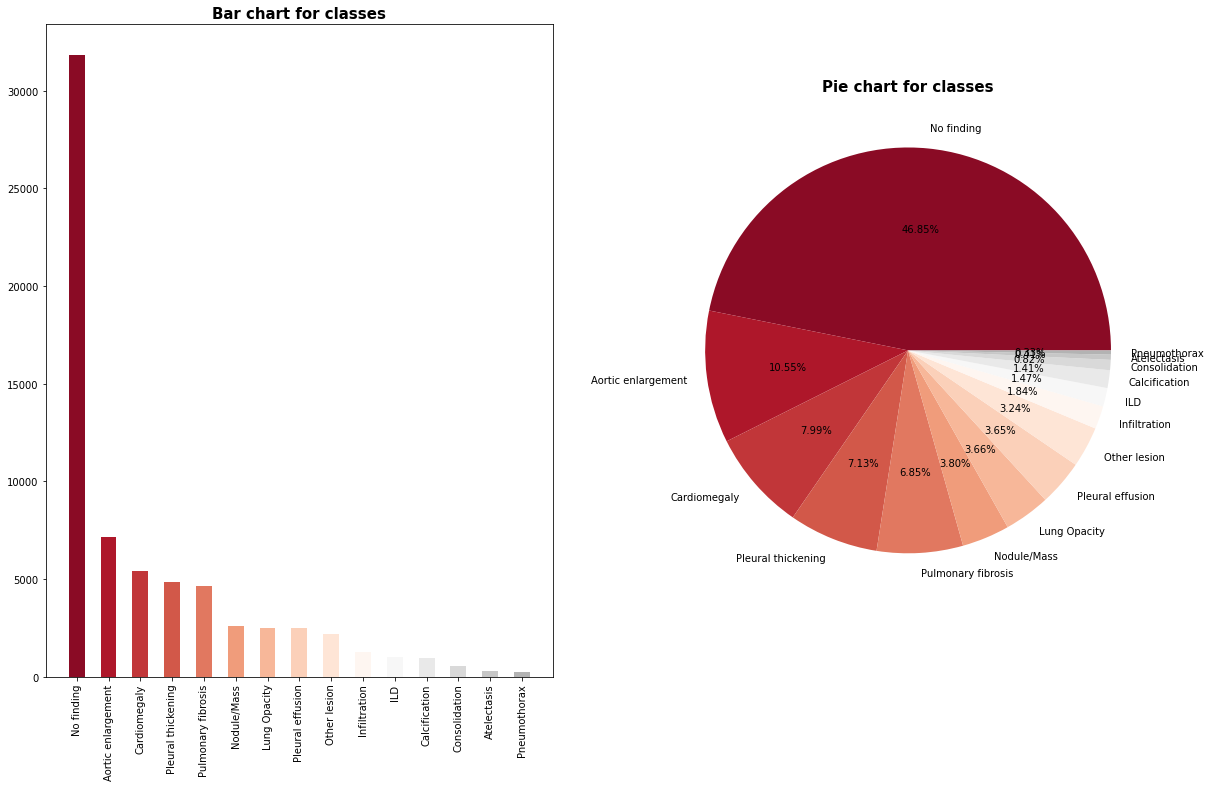

In [17]:
unique_class, count_class = np.unique(train_df["class_name"].values, return_counts=True)
indexes = np.argsort(count_class)[::-1]
fig, axes = plt.subplots(1, 2, figsize=(20, 12))
axes[0].bar(unique_class[indexes], counts[indexes], width=0.5, color=sns.color_palette("RdGy", n_colors=20))
axes[0].set_xticklabels(unique_class[indexes], rotation='90')
axes[0].set_title('Bar chart for classes', fontsize=15, fontweight='bold')

axes[1].pie(count_class[indexes], labels=unique_class[indexes], autopct='%1.2f%%',colors=sns.color_palette("RdGy", n_colors=20))
axes[1].set_title('Pie chart for classes', fontsize=15, fontweight='bold')
plt.show()

In [18]:
train_df.image_id.value_counts()

03e6ecfa6f6fb33dfeac6ca4f9b459c9    57
fa109c087e46fe1ea27e48ce6d154d2f    52
e31be972e181987a8600a8700c1ebe88    48
ecf474d5d4f65d7a3e23370a68b8c6a0    46
6d5acf3f8a973a26844d617fffe72998    46
                                    ..
d56ea61e0f01104d8e27e9372141ecd8     3
f2458e4577d8b480f0380dcd93505b15     3
efbeb0059099d754a3174143968bbe58     3
b40befd17e7095fa289499c2440d0471     3
9fe9c4d06f45815bd3cb8c44dcc11de6     3
Name: image_id, Length: 15000, dtype: int64

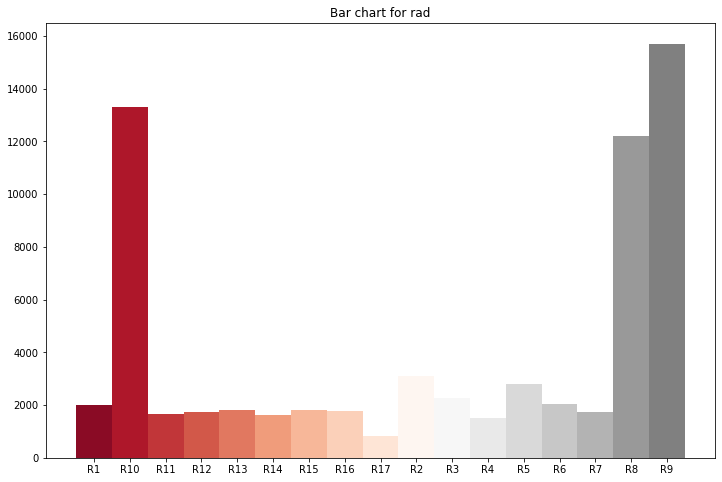

In [19]:
# rad: radiologits
unique_rad, count_rad = np.unique(train_df["rad_id"].values, return_counts=True)
plt.figure(figsize=(12, 8))
plt.bar(unique_rad, count_rad, width=1, color=sns.color_palette("RdGy", n_colors=20))
plt.title("Bar chart for rad")
plt.show()

In [20]:
train_df.isna().sum(axis=0)

image_id          0
class_name        0
class_id          0
rad_id            0
x_min         31818
y_min         31818
x_max         31818
y_max         31818
rad_label         0
dtype: int64

In [21]:
train_df.loc[train_df["class_id"] != 14].isna().sum(axis=0)

image_id      0
class_name    0
class_id      0
rad_id        0
x_min         0
y_min         0
x_max         0
y_max         0
rad_label     0
dtype: int64

In [22]:
new_train_df = train_df[train_df['class_name'] != "No finding"].copy()
new_train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,rad_label
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,1
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,1
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,16
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,8
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,16


In [23]:
new_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36096 entries, 2 to 67912
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    36096 non-null  object 
 1   class_name  36096 non-null  object 
 2   class_id    36096 non-null  int64  
 3   rad_id      36096 non-null  object 
 4   x_min       36096 non-null  float64
 5   y_min       36096 non-null  float64
 6   x_max       36096 non-null  float64
 7   y_max       36096 non-null  float64
 8   rad_label   36096 non-null  int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 2.8+ MB


In [24]:
new_train_df.describe()

,class_id,x_min,y_min,x_max,y_max,rad_label
count,36096.000000,36096.000000,36096.000000,36096.000000,36096.000000,36096.000000
mean,6.435145,1051.332696,1065.262051,1492.269337,1456.660489,10.659824
std,4.573290,565.838078,552.925133,595.384126,581.134138,6.784972
min,0.000000,0.000000,0.000000,68.000000,103.000000,1.000000
25%,3.000000,602.000000,627.000000,1010.000000,1009.000000,1.000000
50%,7.000000,1014.500000,935.000000,1567.000000,1411.000000,15.000000
75%,11.000000,1457.000000,1471.000000,1947.000000,1911.000000,16.000000
max,13.000000,2934.000000,3133.000000,3131.000000,3384.000000,16.000000


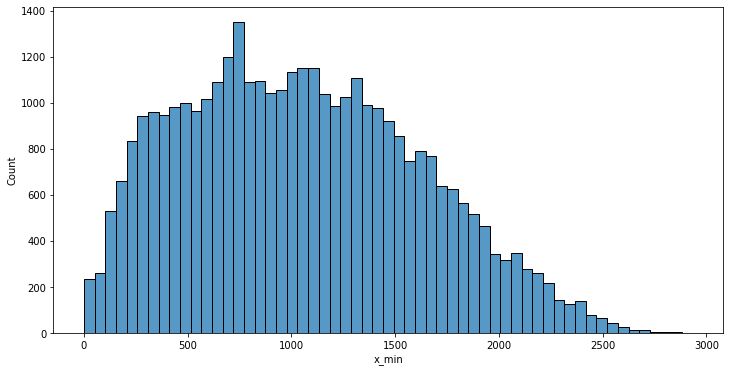

In [38]:
fig = plt.figure(figsize=(12, 6))
sns.histplot(new_train_df['x_min']);

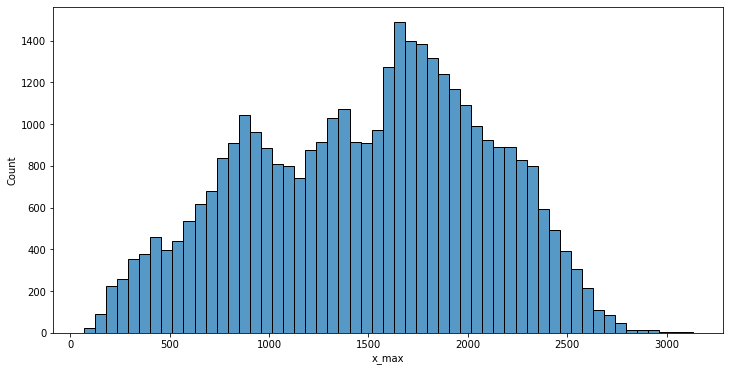

In [37]:
fig = plt.figure(figsize=(12, 6))
sns.histplot(new_train_df['x_max']);

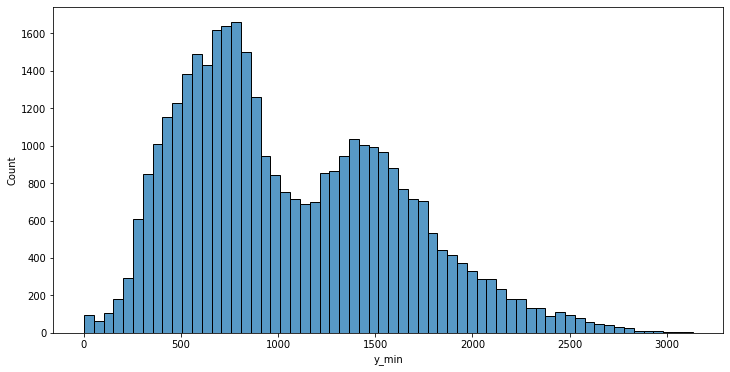

In [36]:
fig = plt.figure(figsize=(12, 6))
sns.histplot(new_train_df['y_min']);

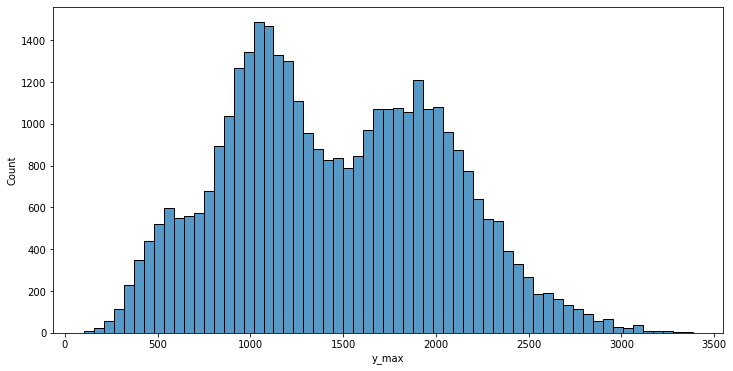

In [35]:
fig = plt.figure(figsize=(12, 6))
sns.histplot(new_train_df['y_max']);

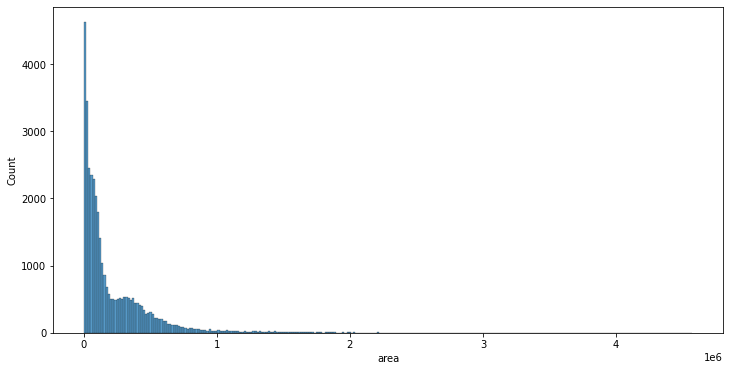

In [34]:
new_train_df["area"] = (new_train_df["x_max"] - new_train_df["x_min"]) * (new_train_df["y_max"] - new_train_df["y_min"])
fig = plt.figure(figsize=(12, 6))
sns.histplot(new_train_df['area']);

In [30]:
new_train_df['area'].describe()

count    3.609600e+04
mean     2.184157e+05
std      2.893798e+05
min      1.800000e+02
25%      3.918950e+04
50%      1.064710e+05
75%      3.119745e+05
max      4.575318e+06
Name: area, dtype: float64

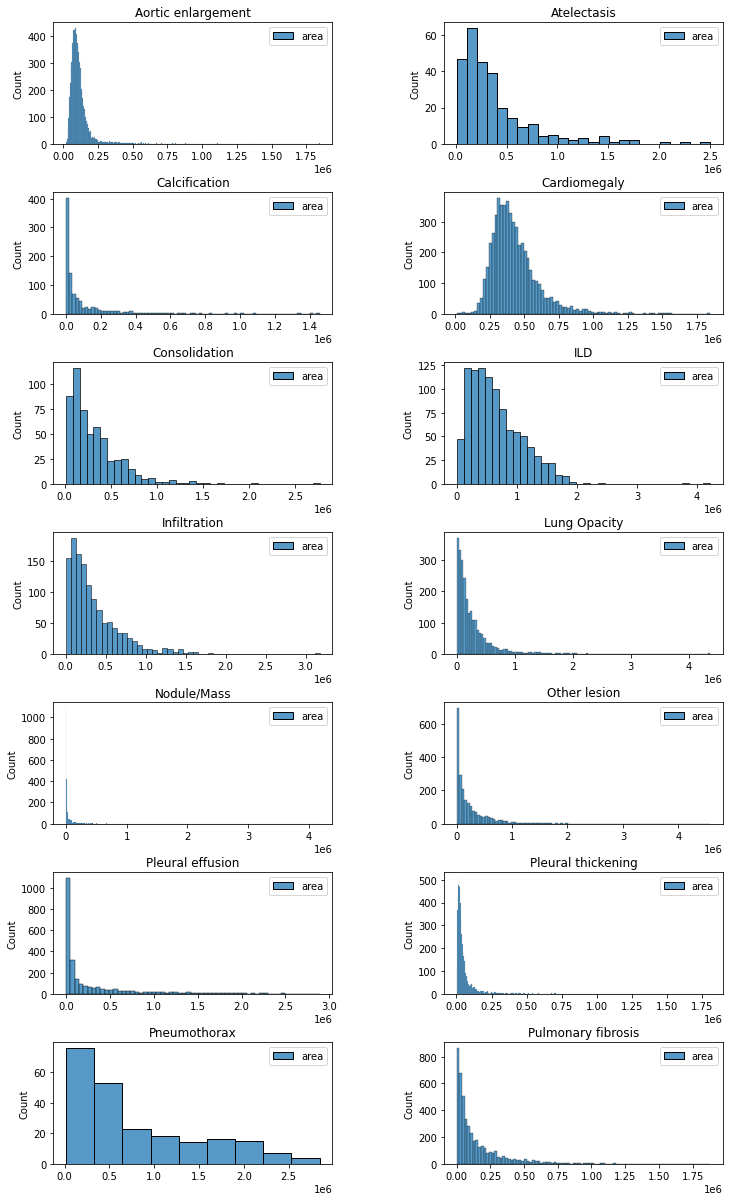

In [33]:
plt.gcf().set_size_inches(12, 21)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for i in range(7):
    for j in range(2):
        plt.subplot(7, 2, i * 2 + j + 1)
        plt.title(classes_name[i * 2 + j])
        sns.histplot(new_train_df.loc[new_train_df["class_id"] == i * 2 + j, ['area']]);
plt.show()